<a href="https://colab.research.google.com/github/EmilianoNicolasPrado/COVID19/blob/main/Covid19_Nicolas_Prado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instalación y Configuración Inicial**

In [66]:
!pip install vaderSentiment # Install vaderSentiment package

**Importación de Librerías**

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

**Descarga de Recursos de NLTK**

In [68]:
#recursos de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

**Carga del Dataset desde GitHub**

In [69]:
#Carga del Dataset
df = pd.read_csv('https://raw.githubusercontent.com/EmilianoNicolasPrado/COVID19/refs/heads/main/COVID19.csv', encoding='latin-1')

In [70]:
print("Dimensiones del dataset:", df.shape)
print("\nColumnas disponibles:", df.columns.tolist())
df.head()

Dimensiones del dataset: (41157, 6)

Columnas disponibles: ['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet', 'Sentiment']


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


**Exploración y Visualización del Sentimiento**

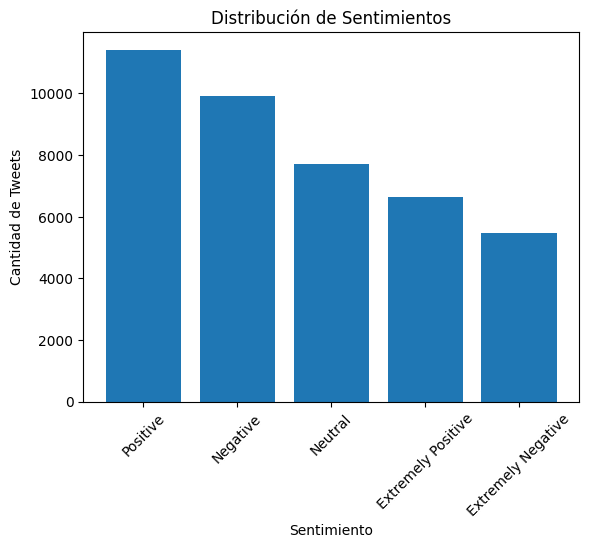

In [71]:
conteo_sentimientos = df['Sentiment'].value_counts()
plt.bar(conteo_sentimientos.index, conteo_sentimientos.values)
plt.title("Distribución de Sentimientos")
plt.xlabel("Sentimiento")
plt.ylabel("Cantidad de Tweets")
plt.xticks(rotation=45)
plt.show()

In [72]:
# Distribución de la columna 'Sentiment'
if 'Sentiment' in df.columns:
    conteo_sentimientos = df['Sentiment'].value_counts()
    print("\nConteo de tweets por sentimiento:\n", conteo_sentimientos)


Conteo de tweets por sentimiento:
 Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64


**Definición de Stopwords y Función de Preprocesamiento**

In [73]:
# Definimos el idioma para stopwords (asumiendo que los tweets están en inglés)
stopwords_en = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [74]:

def preprocess_text(text, use_stemmer=True):
    # 1. Tokenizar
    tokens = word_tokenize(text)

    # 2. Remover stopwords y tokens no alfabéticos
    tokens = [t for t in tokens if t.lower() not in stopwords_en and t.isalpha()]

    # 3. Stemming o Lematización
    if use_stemmer:
        tokens = [stemmer.stem(token.lower()) for token in tokens]
    else:
        tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens]

    # 4. Reunir en un string de vuelta
    return " ".join(tokens)

In [75]:
df['ProcessedTweet'] = df['OriginalTweet'].astype(str).apply(preprocess_text, use_stemmer=True)
df[['OriginalTweet', 'ProcessedTweet']].head(5)

,OriginalTweet,ProcessedTweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,menyrbi chrisitv http http http
1,advice Talk to your neighbours family to excha...,advic talk neighbour famili exchang phone numb...
2,Coronavirus Australia: Woolworths to give elde...,coronaviru australia woolworth give elderli di...
3,My food stock is not the only one which is emp...,food stock one empti pleas panic enough food e...
4,"Me, ready to go at supermarket during the #COV...",readi go supermarket outbreak paranoid food st...


**Análisis de Sentimiento con TextBlob y VADER**

TextBlob

In [76]:
def get_polarity_textblob(text):
    return TextBlob(text).sentiment.polarity  # -1 (neg) a +1 (pos)

df['Polarity_TextBlob'] = df['ProcessedTweet'].apply(get_polarity_textblob)


VADER


In [77]:
vader_analyzer = SentimentIntensityAnalyzer()
def get_vader_compound(text):
    scores = vader_analyzer.polarity_scores(text)
    return scores['compound']  # -1 (neg) a +1 (pos)

df['Vader_Compound'] = df['ProcessedTweet'].apply(get_vader_compound)

**Clasificación Supervisada con TF-IDF + Logistic Regression**

In [78]:
if 'Sentiment' in df.columns:
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df['ProcessedTweet'])  # TF-IDF
    y = df['Sentiment']

    # Separamos en train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Entrenamos Logistic Regression
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    # Exactitud en train/test
    print("Exactitud en entrenamiento:", clf.score(X_train, y_train))
    print("Exactitud en prueba:", clf.score(X_test, y_test))

    # Ejemplo de predicción
    ejemplo = ["I hate how the pandemic is affecting everything!"]
    ejemplo_proc = [preprocess_text(ejemplo[0], use_stemmer=True)]
    ejemplo_vec = vectorizer.transform(ejemplo_proc)
    pred = clf.predict(ejemplo_vec)
    print(f"Ejemplo de texto: {ejemplo[0]}")
    print(f"Texto procesado: {ejemplo_proc[0]}")
    print(f"Sentimiento predicho: {pred[0]}")
else:
    print()

Exactitud en entrenamiento: 0.7774031890660592
Exactitud en prueba: 0.5733722060252673
Ejemplo de texto: I hate how the pandemic is affecting everything!
Texto procesado: hate pandem affect everyth
Sentimiento predicho: Negative
